In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [1]:
# import json
import os
# json_path = os.path.join(os.getenv("HOME"), ".kaggle/kaggle.json")
# j = json.load(open(json_path, 'r'))
# api = KaggleApi(j)
# api.authenticate()
# files = api.competition_download_files("mercedes-benz-greener-manufacturing")

In [3]:
for file_name in os.listdir(os.getcwd()):
    if file_name.endswith(".zip"):
        print(file_name)

mercedes-benz-greener-manufacturing.zip


In [2]:
# os.system("mkdir -p mercedes-benz-greener-manufacturing")
dir_abs_path = os.path.abspath("mercedes-benz-greener-manufacturing")
print(dir_abs_path)
# from shutil import move
# for file_name in os.listdir(os.getcwd()):
#     if file_name.endswith(".zip"):
#         move(file_name, dir_abs_path)

/home/laferrari/github/Machine-Learning-Concepts/src/mercedes-benz-greener-manufacturing


In [3]:
os.chdir(dir_abs_path)
# !unzip mercedes-benz-greener-manufacturing.zip
# !unzip train.csv.zip
# !unzip test.csv.zip
# !unzip sample_submission.csv.zip

In [4]:
train_csv, test_csv, submission_csv = "", "", ""
for file_name in os.listdir(dir_abs_path):
    if file_name.endswith(".csv"):
        if file_name.startswith("train"):
            train_csv = os.path.join(dir_abs_path, file_name)
        elif file_name.startswith("test"):
            test_csv = os.path.join(dir_abs_path, file_name)
        elif file_name.startswith("sample"):
            submission_csv = os.path.join(dir_abs_path, file_name)
print(train_csv, test_csv, submission_csv)

/home/laferrari/github/Machine-Learning-Concepts/src/mercedes-benz-greener-manufacturing/train.csv /home/laferrari/github/Machine-Learning-Concepts/src/mercedes-benz-greener-manufacturing/test.csv /home/laferrari/github/Machine-Learning-Concepts/src/mercedes-benz-greener-manufacturing/sample_submission.csv


In [2]:
import pandas as pd
from IPython.display import display
df = pd.read_csv(train_csv)
display(df.head())

y - value to be predicted
X0-X385 - features of a mercedes benz

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


hence only 8 categorical features, 369 integer type features and 1 float-type feature

In [7]:
cols, categorical_features = df.columns, []
for col in cols:
    if df[col].dtype == 'object':
        categorical_features.append(col)
print(categorical_features)

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


In [9]:
# unique labels for each feature, i.e. all categories of each feature
for col in categorical_features:
    print(col, "-", len(df[col].unique()))

X0 - 47
X1 - 27
X2 - 44
X3 - 7
X4 - 4
X5 - 29
X6 - 12
X8 - 25


In [10]:
pd.get_dummies(df, drop_first=True).shape

(4209, 557)

if the total number of categories, for even 1 categorical feature are ~500, then it would correspond to 500-dimensional one-hot encoding, which will lead to increase in the dimensionality of our net feature vector, which may impact the accuracy 

A similar problem is what we would face if we decide to include all of these 557 one-hot encoded features.
According to the niculescu's solution that won the KDD2009 cup, the one-hot encoding was limited to only the 10 most frequent labels(of each categorical feature). Hence the other labels will be then clubbed into a single category, which then will be dropped.

hence the newly created 10 dummy variables would indicate whether the sample belongs to a frequently occuring label(exactly 1 label will be set to 1 for that categorical feature), or doesn't belong to any of the 10 most frequently occuring labels(all set to 0)

In [11]:
for col in categorical_features:
    print(dict(df[col].value_counts()[:10]))

{'z': 360, 'ak': 349, 'y': 324, 'ay': 313, 't': 306, 'x': 300, 'o': 269, 'f': 227, 'n': 195, 'w': 182}
{'aa': 833, 's': 598, 'b': 592, 'l': 590, 'v': 408, 'r': 251, 'i': 203, 'a': 143, 'c': 121, 'o': 82}
{'as': 1659, 'ae': 496, 'ai': 415, 'm': 367, 'ak': 265, 'r': 153, 'n': 137, 's': 94, 'f': 87, 'e': 81}
{'c': 1942, 'f': 1076, 'a': 440, 'd': 290, 'g': 241, 'e': 163, 'b': 57}
{'d': 4205, 'a': 2, 'b': 1, 'c': 1}
{'v': 231, 'w': 231, 'q': 220, 'r': 215, 's': 214, 'd': 214, 'n': 212, 'm': 208, 'p': 208, 'i': 207}
{'g': 1042, 'j': 1039, 'd': 625, 'i': 488, 'l': 478, 'a': 206, 'h': 190, 'k': 43, 'c': 38, 'b': 28}
{'j': 277, 's': 255, 'f': 243, 'n': 242, 'i': 237, 'e': 225, 'r': 219, 'a': 210, 'w': 196, 'v': 194}


In [12]:
import numpy as np
df_copy = df.copy()
for col in categorical_features:
    top_10 = list(df[col].value_counts()[:10].keys())
    for label in top_10:
        df_copy[col+"_"+label] = np.where(df[col] == label, 1, 0)
df_copy.drop(categorical_features, axis=1, inplace=True)
for col in categorical_features:
    top_10 = list(df[col].value_counts()[:10].keys())
    top_10 = list(map(lambda x: col+"_"+x, top_10))
    display(df_copy.loc[:, top_10].head(10))

,X0_z,X0_ak,X0_y,X0_ay,X0_t,X0_x,X0_o,X0_f,X0_n,X0_w
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0


,X1_aa,X1_s,X1_b,X1_l,X1_v,X1_r,X1_i,X1_a,X1_c,X1_o
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0


,X2_as,X2_ae,X2_ai,X2_m,X2_ak,X2_r,X2_n,X2_s,X2_f,X2_e
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,1
7,1,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


,X3_c,X3_f,X3_a,X3_d,X3_g,X3_e,X3_b
0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
5,1,0,0,0,0,0,0
6,0,1,0,0,0,0,0
7,0,1,0,0,0,0,0
8,0,0,0,0,0,1,0
9,1,0,0,0,0,0,0


,X4_d,X4_a,X4_b,X4_c
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0
6,1,0,0,0
7,1,0,0,0
8,1,0,0,0
9,1,0,0,0


,X5_v,X5_w,X5_q,X5_r,X5_s,X5_d,X5_n,X5_m,X5_p,X5_i
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


,X6_g,X6_j,X6_d,X6_i,X6_l,X6_a,X6_h,X6_k,X6_c,X6_b
0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,0,1,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0


,X8_j,X8_s,X8_f,X8_n,X8_i,X8_e,X8_r,X8_a,X8_w,X8_v
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0


<font size="5" color="green">Advantages of One-hot encoding ONLY the top-10 labels per category</font>
* straightforward to implement
* doesn't require in-depth variable exploration
* prevents massive expansion of the feature space

<font size="5" color="red">DISAdvantages of One-hot encoding ONLY the top-10 labels per category</font>
* doesn't add any information that may make the variable productive
* ignores the information from the less frequent labels

hence the other labels per category which appear less frequently, are regarded as NOISE.

# Types of Encoding

1. Nominal Encoding - corresponds to nominal features
2. Ordinal Encoding - corresponds to ordinal features

## Nominal Features
* no need to worry about arrangement of the categories in a feature

## Ordinal Features
* arrangement of the categories in a feature is important
* each category of an ordinal feature has some rank associated to it
* suppose salary prediction based on a feature= education
 * education = BE, Bcom, Masters, PHD
 * assumption = salary-order : PHD > Masters > BE > Bcom
 * hence PHD - 1, Masters - 2, BE - 3, Bcom - 4
 
# Nominal Encoding
3 basic techniques:
1. One-hot encoding
2. One-hot encoding with many categorical variables
3. Mean encoding

# One-hot encoding
1. one-hot vector representations
2. number of columns = number of unique categories for a feature
3. column set to 1 if the sample's feature value is that particular label, else set to 0
4. the new columns created as a result are called as *dummy variables*

## Dummy variable trap
1. suppose we have 3 categories for a feature, A, B, C.
2. instead of having 3 columns, we can have 2 columns, A, B, where 
    1. if the label = A, then the column A can be set to 1 and B will be set to 0
    2. if label = B, then the column A can be set to 0 and B will be set to 1
    3. if label = C, then both columns A and B will be set to 1
3. hence, **we use the drop_first=True**, while using the *pandas.get_dummies* function

## <font color="red">DISadvantages</font>
1. the obvious increase in dimensionality , which causes <font color="red">curse of dimensionality</font>

# One-hot encoding *with multiple categories*
1. since we had decided that to avoid the *curse of dimensionality*, avoid one-hot encoding for features with numerous categories, we need to have some other way to encode them
2. one way to go about such an issue is to use the *top-10 categories encode only* method, which was done during the KDD-orange competition 

# Mean encoding
1. calculate the mean value of output(also called target variable) per category for such a feature
2. assign the mean value as a value that represents this feature
3. this is also used when the number of categories is just too large for one-hot encoding to be properly used
4. in addition to this, a new column that denotes the standard deviation(or variance) of the target variable w.r.t. the same category can also be introduced, to make up for low-predicitve power.

In [68]:
titanic_df = df.copy()
titanic_df['mean-encoded'] = titanic_df['Cabin'].astype(str).str[0]
mean_encoding_dict = titanic_df.groupby(['mean-encoded'])['Survived'].mean().to_dict()
titanic_df['mean-encoded'] = titanic_df['mean-encoded'].map(mean_encoding_dict)
display(titanic_df.head(15))

,Survived,Cabin,new-cabin,mean-encoded
0,0,NaN,1,0.299854
1,1,C85,4,0.593220
2,1,NaN,1,0.299854
3,1,C123,4,0.593220
4,0,NaN,1,0.299854
5,0,NaN,1,0.299854
6,0,E46,7,0.750000
7,0,NaN,1,0.299854
8,1,NaN,1,0.299854
9,1,NaN,1,0.299854


try to compare this with:
1. target-guided ordinal encoding
2. null-value filling up using mode + encoding with any other method

# Ordinal Encoding
2 basic techniques:
1. Label Encoding
2. Target-guided ordinal encoding

[Follow this for more](https://www.kaggle.com/scirpus/ordinal-encoding/comments)

# Label Encoding
1. highest importance/lowest rank(lowest integral value, i.e. rank = 1 means it should be assigned the highest available value)
    1. for the example of education = BE, Bcom, Masters, PHD, the corresponding values will be PHD=4, Masters=3, BE=2, Bcom=1
2. use [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) for this

# Target-guided ordinal encoding
1. try to find out the mean of the output(to be predicted) values for each category of such a feature
    1. this should be done only after converting the output variables into an integral form, if they weren't in the first place
2. if suppose c = number of categories a feature has, then there will be C means to compare from
3. based on these C number of means, assign top rank(superior, large number, just like PHD in the label-encoding example) to a category if it has the highest mean of all the remaining unassigned categories.

In [27]:
os.chdir("./titanic-dataset")
!unzip titanic.zip
train_csv = os.path.join(os.getcwd(), "train.csv")
os.chdir("../")
print(os.getcwd())

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
/home/laferrari/github/Machine-Learning-Concepts/src


In [30]:
df = pd.read_csv(train_csv, usecols=['Cabin', 'Survived'])
df.head(10)

,Survived,Cabin
0,0,NaN
1,1,C85
2,1,NaN
3,1,C123
4,0,NaN
5,0,NaN
6,0,E46
7,0,NaN
8,1,NaN
9,1,NaN


In [32]:
print(list(df['Cabin'].value_counts().keys()))

['B96 B98', 'C23 C25 C27', 'G6', 'D', 'F33', 'F2', 'E101', 'C22 C26', 'D20', 'C126', 'D33', 'D35', 'D17', 'B20', 'C78', 'B22', 'E25', 'E33', 'E67', 'C92', 'F G73', 'E24', 'C2', 'C93', 'C125', 'E8', 'C68', 'B18', 'E121', 'B28', 'C52', 'C123', 'B57 B59 B63 B66', 'C83', 'B58 B60', 'D26', 'B49', 'C65', 'B35', 'E44', 'B5', 'F4', 'B77', 'C124', 'B51 B53 B55', 'D36', 'E46', 'E31', 'D30', 'C110', 'C46', 'D15', 'F E69', 'D9', 'B3', 'B30', 'F38', 'E50', 'E58', 'E40', 'B101', 'T', 'C50', 'D10 D12', 'B82 B84', 'C70', 'B69', 'D46', 'E36', 'C87', 'B71', 'C128', 'D56', 'B102', 'E34', 'D48', 'E12', 'D37', 'D28', 'B80', 'E68', 'D49', 'A6', 'B38', 'A19', 'E38', 'A26', 'E10', 'C111', 'A7', 'B19', 'A31', 'E17', 'A20', 'C86', 'E49', 'C101', 'A36', 'A32', 'B73', 'C106', 'D47', 'B78', 'C90', 'D21', 'A34', 'C32', 'E63', 'C99', 'C118', 'D45', 'A24', 'C91', 'D6', 'C103', 'A5', 'C148', 'B39', 'D7', 'C85', 'C62 C64', 'B79', 'C104', 'E77', 'C95', 'A23', 'C47', 'B37', 'A10', 'C49', 'C82', 'B86', 'B94', 'B42', 'B4',

<font size="5" color="red">for this feature = Cabin, each sample will mostly be assigned to a unique category(unique seat), we would rather like to count the frequencies for each row(A/B/C..) rather than frequency of each particular seat </font>

In [35]:
# this will print the first alphabet of each Cabin-category, for each sample
print(df['Cabin'].astype(str).str[0], "\n\n")
print(df['Cabin'].astype(str).str[0].value_counts())

0      n
1      C
2      n
3      C
4      n
      ..
886    n
887    B
888    n
889    C
890    n
Name: Cabin, Length: 891, dtype: object 


n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64


we can see that there are many NaN values, and the row with the highest frequency is C

In [44]:
# this will ignore the NaN values, which are being represented by the alphabet lowercase-n.
categories = list(df['Cabin'].dropna().astype(str).str[0].value_counts().keys())
print(categories)
print(df[df['Cabin'].astype(str).str[0] == categories[0]].mean())

['C', 'B', 'D', 'E', 'A', 'F', 'G', 'T']
Survived    0.59322
dtype: float64


In [62]:
# create new-column having only the first alphabet that signifies row-value of a seat
df['new-cabin'] = df['Cabin'].astype(str).str[0]

'''
group all row-types using the Survival(the target variable, i.e. the output) and
take mean w.r.t. each category, and then sort and obtain indices for all
sorted elements in the pandas.Series object
'''
ordinal_indices = df.groupby(['new-cabin'])['Survived'].mean().sort_values().index

# create a dictionary to encode the ordinal labels to their respective ranks
ordinal_ranks = {k:i for i, k in enumerate(ordinal_indices, 0)}
print(ordinal_ranks)
df['new-cabin'] = df['new-cabin'].map(ordinal_ranks)
display(df.head(15))

{'T': 0, 'n': 1, 'A': 2, 'G': 3, 'C': 4, 'F': 5, 'B': 6, 'E': 7, 'D': 8}


,Survived,Cabin,new-cabin
0,0,NaN,1
1,1,C85,4
2,1,NaN,1
3,1,C123,4
4,0,NaN,1
5,0,NaN,1
6,0,E46,7
7,0,NaN,1
8,1,NaN,1
9,1,NaN,1


1. null values are replace by an appropriately encoded variable
2. this captures the information regarding *missingness of data*
3. new feature added but the old one can now be deleted, hence <font color="green">no net dimensionality change</font>

**try this and compare it against mode-based replacement+some other encoding method to encode all categorical variables**

# Frequency Encoding
* replace each label of a categorical variable by a count - amount of times that label has appeared in the dataset
* usually to be used when a categorical feature has to many categories, due to which one-hot encoding is certain to cause *curse of dimensionality*
* frequency(count/total_count) can also be used, instead of the actual count value
* valid coding in case of GBM based models like xgboost. <font color="Red">How?</font>
* **KDD-2014 solutions**

In [8]:
df_freq = df.copy()

In [9]:
for col in categorical_features:
    d = dict(df_freq[col].value_counts())
    df_freq[col] = df_freq[col].map(d)
display(df_freq.head(10))

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,11,408,6,440,4205,1,1039,163,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,11,31,4,163,4205,1,478,163,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,175,52,137,1942,4205,2,1039,105,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,175,31,137,1076,4205,2,478,225,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,175,408,137,1076,4205,1,625,242,...,0,0,0,0,0,0,0,0,0,0
5,18,92.93,306,592,81,1942,4205,1,190,255,...,0,0,1,0,0,0,0,0,0,0
6,24,128.76,67,251,81,1076,4205,7,190,255,...,0,0,0,0,0,0,0,0,0,0
7,25,91.91,269,590,1659,1076,4205,7,1039,210,...,0,0,0,0,0,0,0,0,0,0
8,27,108.67,182,598,1659,163,4205,7,488,117,...,1,0,0,0,0,0,0,0,0,0
9,30,126.99,181,592,63,1942,4205,7,206,225,...,0,0,1,0,0,0,0,0,0,0


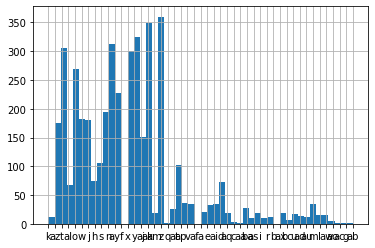

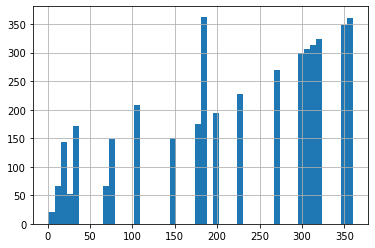

In [10]:
import matplotlib.pyplot as plt

df['X0'].hist(bins=50)
plt.show()
df_freq['X0'].hist(bins=50)
plt.show()

In [21]:
print(df['X0'].mode()[0], df['X0'].value_counts().keys()[0])

z z


<font size="5" color="green">Advantages of frequency encoding</font>
1. simple to implement
2. does not increase the feature-dimensional space

<font size="5" color="red">DISAdvantages of frequency encoding</font>
1. if labels do have the same frequency value, then such features will loose uniqueness information with respect to a sample belonging to label-1 or label-2.
2. the numbers thus added may not be related to the predictive power.

Alternatives would be to use MCA(PCA for categorical features)

# Probability-ratio encoding
1. probability ratio = prob(c=P)/prob(c=N), where P - positive class, N - negative class(this is w.r.t. binary classification)
2. here P = (survived=1), N = (survived=0)

In [9]:
df = pd.read_csv("./titanic-dataset/train.csv", usecols=['Cabin', 'Survived'])

# this will ignore the NaN values, which are being represented by the alphabet lowercase-n.
categories = list(df['Cabin'].astype(str).str[0].value_counts().keys())
print(categories)

# create new-column having only the first alphabet that signifies row-value of a seat
df['new-cabin'] = df['Cabin'].astype(str).str[0]

print(df.groupby(['new-cabin'])['Survived'].mean())

prob_df = pd.DataFrame(df.groupby(['new-cabin'])['Survived'].mean())
prob_df['Died'] = 1 - prob_df['Survived']
prob_df['ratio'] = prob_df['Survived']/prob_df['Died']
display(prob_df)

map_dict = prob_df['ratio'].to_dict()
print(map_dict)

df['new-cabin'] = df['new-cabin'].map(map_dict)
display(df.head(10))

['n', 'C', 'B', 'D', 'E', 'A', 'F', 'G', 'T']
new-cabin
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64


,Survived,Died,ratio
new-cabin,,,
A,0.466667,0.533333,0.875000
B,0.744681,0.255319,2.916667
C,0.593220,0.406780,1.458333
D,0.757576,0.242424,3.125000
E,0.750000,0.250000,3.000000
F,0.615385,0.384615,1.600000
G,0.500000,0.500000,1.000000
T,0.000000,1.000000,0.000000
n,0.299854,0.700146,0.428274


{'A': 0.875, 'B': 2.916666666666666, 'C': 1.4583333333333333, 'D': 3.125, 'E': 3.0, 'F': 1.6000000000000003, 'G': 1.0, 'T': 0.0, 'n': 0.42827442827442824}


,Survived,Cabin,new-cabin
0,0,NaN,0.428274
1,1,C85,1.458333
2,1,NaN,0.428274
3,1,C123,1.458333
4,0,NaN,0.428274
5,0,NaN,0.428274
6,0,E46,3.000000
7,0,NaN,0.428274
8,1,NaN,0.428274
9,1,NaN,0.428274


lets see their performances on kaggle

<font size="6">[Please visit this link tomorrow](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)</font>

# MCAR
* values that are missing completely at random
* missing values are a random subset of the data
* no relation between the missing data and the data that is present in the entire dataset
* nothing systematic going on that makes a data more likely to be missing than the other

# Handle missing values in categorical variables
1. Delete the rows
    1. delete the row that has a null value for a particular categorical variable
    2. obvious consequence is reduction of the train size, and also if the test data contains null values for this particular variable, then the model doesn't know of how to handle prediction of an input sample with this variable set to NULL, thus messing up the accuracy
    3. it may also happen that the rows being deleted by one categorical feature, may impact special knowledge which would have been otherwise derived by the model, had the rows been not deleted, w.r.t. some other feature.

2. replace with the most frequent values, i.e. the mode for that categorical variable
    1. already saw in the house-prices advanced regression technique problem that usage of mode of the train data, to fill the null values for both test and train data yielded better score than the usage of mode of train data to fill the null values for train data and usage of mode of test-data to fill its own null values
    2. this may lead to an **imbalanced dataset**, since a particular value may be repeating too many times, but the presence of the other value might be a key aspect of learning/prediction.
3. use a classifier
    1. to predict what the null value should be, from the other available features for this sample, use a classifier
    2. we can include the output variable as an independent variable as well, in this particular classification
4. apply an unsupervied-ML technique
    1. if clustering is to be used, then use all other feature vectors for clustering, to create N clusters, where each cluster represents a particular category of this missing-value feature.
5. introduction of new feature to capture NaN values
    1. just like in continuous variables, introduce a new column, having an extra category = "missing" to denote the NaN value
    2. drop the original column to avoid curse of dimensionality
    

# Handle missing values for continuous/quantitative variables
* mean/median/mode imputation
* random sample imputation
* capturing NaN values with a new feature
* end of distribution imputation
* arbitrary imputation
* frequent categories imputation

In [6]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

json_path = os.path.join(os.getenv("HOME"), ".kaggle/kaggle.json")
j = json.load(open(json_path, 'r'))
api = KaggleApi(j)
api.authenticate()

os.system("mkdir -p titanic-dataset")
os.chdir("./titanic-dataset")
files = api.competition_download_files("titanic")
!unzip titanic.zip
os.listdir("./")

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


['test.csv', 'gender_submission.csv', 'train.csv', 'titanic.zip']

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

df = pd.read_csv("./train.csv", usecols=['Age', 'Fare', 'Survived'])
display(df.head(10))
print(df.isnull().mean())

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500
5,0,NaN,8.4583
6,0,54.0,51.8625
7,0,2.0,21.0750
8,1,27.0,11.1333
9,1,14.0,30.0708


Survived    0.000000
Age         0.198653
Fare        0.000000
dtype: float64


# Mean/Median/mode imputation
* has the assumption that the data is MCAR(missing completely at random)
* in case of outliers, apply median/mode instead of mean
* <font color="red">change in variance while performing this imputation</font>
* <font color="red">impacts correlation of features</font>

In [13]:
print(df['Age'].std())
print(df['Age_median'].std())

14.526497332334044
13.019696550973194


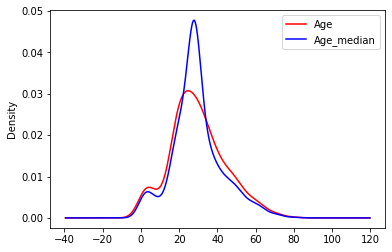

In [11]:
df['Age_median'] = df['Age'].fillna(df['Age'].median())

# plot the values
fig = plt.figure()
ax = fig.add_subplot(111)
df['Age'].plot(kind='kde', ax=ax, color='red') # kde - kernel density estimator
df['Age_median'].plot(kind='kde', ax=ax, color='blue')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

# Random sample imputation
* out of the non-NaN values for that quantitative variable, choose a value at random and assign it to a sample that has a NULL value w.r.t. this particular variable
* has the assumption that the data is MCAR(missing completely at random)
* <font color="green">Distortion w.r.t. variance is close to none</font>
* <font color="red">in every scenario, randomness wont work</font>, , for instance in a competition, it might work, since the end goal is to obtain the best score, but w.r.t. business analytics, the story might be completely different

In [52]:
# this will fetch us 4 random values of age, from all the non-null values of age
print(df['Age'].dropna().sample(4))

# since we want to fill up all NaN values for column age,
# total number of values to be sampled should be
# the same as the total number of NaN values.
df['Age_random'] = df['Age']
random_sample = df['Age'].dropna().sample(df['Age'].isnull().sum(), random_state=42)
print(type(random_sample))
print("\n", random_sample.index, "\n")

# index of all rows having Age as NaN
print(list(df[df['Age'].isnull()].index), "\n\n")

# rearrange index of random_sample to become those of all NaN values w.r.t. Age
random_sample.index = df[df['Age'].isnull()].index

# find index of all Age-NaN values, so that they can be replaced
# with the randoml sampled Age values
print(df.loc[df['Age'].isnull(), :])
df.loc[df['Age'].isnull(), 'Age_random'] = random_sample

385    18.0
348     3.0
672    70.0
705    39.0
Name: Age, dtype: float64
<class 'pandas.core.series.Series'>

 Int64Index([149, 407,  53, 369, 818, 549,  85, 774, 100, 816,
            ...
            569, 291,  80, 487, 546,  38, 247, 445, 323, 714],
           dtype='int64', length=177) 

[5, 17, 19, 26, 28, 29, 31, 32, 36, 42, 45, 46, 47, 48, 55, 64, 65, 76, 77, 82, 87, 95, 101, 107, 109, 121, 126, 128, 140, 154, 158, 159, 166, 168, 176, 180, 181, 185, 186, 196, 198, 201, 214, 223, 229, 235, 240, 241, 250, 256, 260, 264, 270, 274, 277, 284, 295, 298, 300, 301, 303, 304, 306, 324, 330, 334, 335, 347, 351, 354, 358, 359, 364, 367, 368, 375, 384, 388, 409, 410, 411, 413, 415, 420, 425, 428, 431, 444, 451, 454, 457, 459, 464, 466, 468, 470, 475, 481, 485, 490, 495, 497, 502, 507, 511, 517, 522, 524, 527, 531, 533, 538, 547, 552, 557, 560, 563, 564, 568, 573, 578, 584, 589, 593, 596, 598, 601, 602, 611, 612, 613, 629, 633, 639, 643, 648, 650, 653, 656, 667, 669, 674, 680, 692, 697, 709,

In [55]:
# just to verify
print(df['Age'].isnull().sum(), df['Age_median'].isnull().sum(), df['Age_random'].isnull().sum())

177 0 0


In [56]:
# also printing out the variance
print(df['Age'].std(), df['Age_median'].std(), df['Age_random'].std())

14.526497332334044 13.019696550973194 14.295286948654615


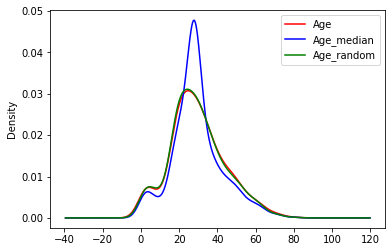

In [53]:
# plot the values
fig = plt.figure()
ax = fig.add_subplot(111)
df['Age'].plot(kind='kde', ax=ax, color='red') # kde - kernel density estimator
df['Age_median'].plot(kind='kde', ax=ax, color='blue')
df['Age_random'].plot(kind='kde', ax=ax, color='green')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

# Capturing NaN values with a new feature

* works well if data is not MCAR

In [57]:
df['Age_NaN'] = np.where(df['Age'].isnull(), 1, 0)

this will result in the NaN values of Age being mapped to 1, and the non-NaN values of Age being mapped to 0, which hopefully our model should be able to figure out.

* easy to implement
* captures information of missing values(the fact that values are missing is being kept as a piece of information through this method)
* <font color="red">curse of dimensionality</font>

# End of distribution imputation
* plot histogram distribution  of the feature that has missing values, then observe the ends(ending values on x-axis) of this distribution
    * the ends mean take the values x $\ge \mu$+3$\sigma$
* outliers are handled
* captures **importance of missingness** of a particular feature.
* <font color="red">Variance is severely distorted</font>
* <font color="red">if missingness not important, predictive power of the original variable is masked due to the aforementioned distortion</font>
* <font color="red">if total number of missing values is large, the outliers will be masked(since the outliers will now become the part of the main distribution, and not only that, they might exist as a peak in the histogram distribution</font>
* <font color="red">if total number of missing values is small, the replaced NA value($\mu + 3\sigma$) will be considered as an outlier and get pre-processed in the subsequent feature-engineering techniques</font>

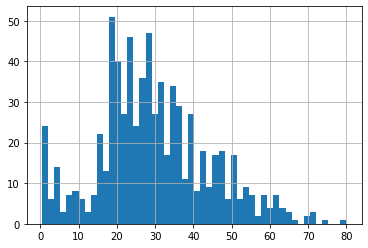

In [58]:
# this is the distribution
df['Age'].hist(bins=50)
plt.show()

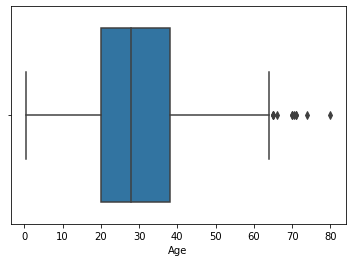

In [60]:
import seaborn as sb
sb.boxplot('Age', data=df)
plt.show()

* this tells us that the majority of the distribution is around the 20-40 region,25-percentile distribution at 20, 50-percentile at Age=30, 75 percentile at age=40
* The diamonds that we see denote the outliers

In [62]:
eod = df['Age'].mean() + df['Age'].std()*3
print(eod)

df['Age_eod'] = df['Age'].fillna(eod)

73.27860964406095


In [64]:
print(
    "Standard deviation of median is", 
    df['Age_median'].std(),
    "\nStandard deviation of random sampling is", 
    df['Age_random'].std(),
    "\nStandard deviation of end-of-distribution is", 
    df['Age_eod'].std()
)

Standard deviation of median is 13.019696550973194 
Standard deviation of random sampling is 14.295286948654615 
Standard deviation of end-of-distribution is 21.719150677136366


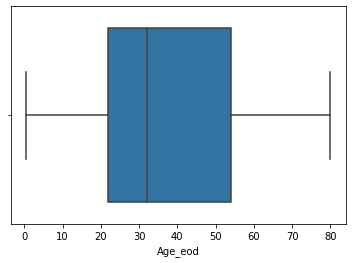

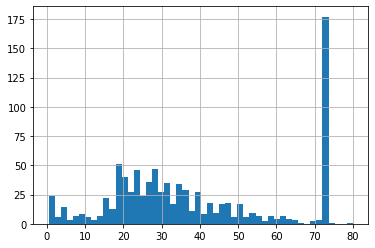

In [68]:
sb.boxplot('Age_eod', data=df)
plt.show()

df['Age_eod'].hist(bins=50)
plt.show()

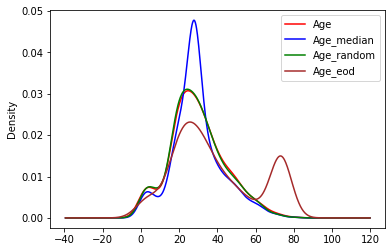

In [66]:
# plot the values
fig = plt.figure()
ax = fig.add_subplot(111)
df['Age'].plot(kind='kde', ax=ax, color='red') # kde - kernel density estimator
df['Age_median'].plot(kind='kde', ax=ax, color='blue')
df['Age_random'].plot(kind='kde', ax=ax, color='green')
df['Age_eod'].plot(kind='kde', ax=ax, color='brown')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

# Arbitrary imputation
* replace NaN values with outliers, either the left-side outliers(close to 0, in case of Age) or right-side outliers(>=80, in case of Age)
* advantages and disadvantages are same as those of end-of-distribution method

<font size="6" >Why do we require feature scaling?</font>
1. if suppose feature values are always large, for non-categorical features, then it may seem for some model(s) that the samples are too distant/too different
    1. for instance, consider the kNN classifier, if suppose height = cm, weight = kg, predicted-label = BMI
    2. consider 2 points, h1 = 180cm, w1 = 78kg, h2 = 170cm, w2 = 84kg
    3. for kNN, it will plot the points as x vs. y plots, and it would see that the euclidean distances between these points is large
    4. hence there is a need to scale down these values
2. there are many different types of scaling, the most common being normalisation across each feature

<font size="4.5">Models that would require feature scaling:</font>
* Linear Regression
    * convergence can take place quickly, since before scaling, it may seem that the model's current state is far from the minima, but after scaling, it may seem that its actually much closer(this is all because of small values vs larger values being compared)
* Models that use euclidean distances, like kNN classifier and K-Means clustering
* Deep-learning models

<font size="4.5">Models that would </font><font color="red" size="4.5">NOT</font><font size="4.5"> require feature scaling:</font>
* Decision Trees - number of branches will remain the same, scaling down wont change the tree structure
* RandomForest
* XGBoost

# techniques for scaling
1. normalisation and standardisation(standard-scaler)
2. scaling to minimum and maximum values(min-max scaler)
3. scaling to median and quantiles(robust-scaler)
4. Gaussian Transformation
    1. Logarthmic transformation
    2. reciprocal transformation
    3. square root transformation
    4. exponential transformation
    5. Box Cox transformation

# Standardisation
1. bring all variables to a similar scale
    1. take the BMI estimation example, weight in grams, height in cm, then if suppose kNN-classifier used, or even something else is used, then 2 points which might actually have equal BMI, can have varying Manhattan/Euclidean distances, and to counter this.
2. x = $\large \frac{\textrm{x}-\mu}{\sigma}$
    

,Survived,Pclass,Age,Fare
0,0,3,22.0,7.2500
1,1,1,38.0,71.2833
2,1,3,26.0,7.9250
3,1,1,35.0,53.1000
4,0,3,35.0,8.0500
5,0,3,NaN,8.4583
6,0,1,54.0,51.8625
7,0,3,2.0,21.0750
8,1,3,27.0,11.1333
9,1,2,14.0,30.0708


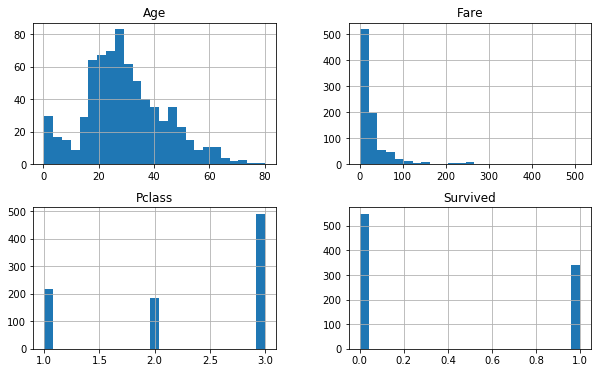

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


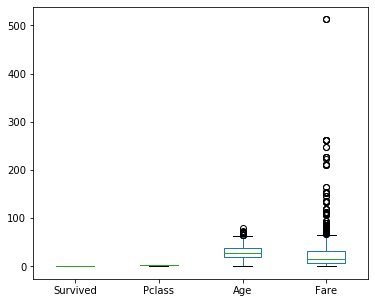

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

df = pd.read_csv("./titanic-dataset/train.csv", usecols=['Pclass', 'Age', 'Fare', 'Survived'])
display(df.head(10))

# initial distribution of data
df.hist(bins=25, figsize=(10, 6))
plt.show()
df.boxplot(grid=False, figsize=(6, 5))
plt.show()

In [2]:
display(df.isnull().sum())

Survived      0
Pclass        0
Age         177
Fare          0
dtype: int64

In [3]:
# fill up Age-NaN values
df['Age'].fillna(df['Age'].median(), inplace=True)
display(df.isnull().sum())

Survived    0
Pclass      0
Age         0
Fare        0
dtype: int64

In [4]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler(copy=False)
df = pd.DataFrame(ss.fit_transform(df), columns=df.columns)

# transformation occurs feature-wise, i.e. column
# wise and not row-wise

display(df)

,Survived,Pclass,Age,Fare
0,-0.789272,0.827377,-0.565736,-0.502445
1,1.266990,-1.566107,0.663861,0.786845
2,1.266990,0.827377,-0.258337,-0.488854
3,1.266990,-1.566107,0.433312,0.420730
4,-0.789272,0.827377,0.433312,-0.486337
...,...,...,...,...
886,-0.789272,-0.369365,-0.181487,-0.386671
887,1.266990,-1.566107,-0.796286,-0.044381
888,-0.789272,0.827377,-0.104637,-0.176263
889,1.266990,-1.566107,-0.258337,-0.044381


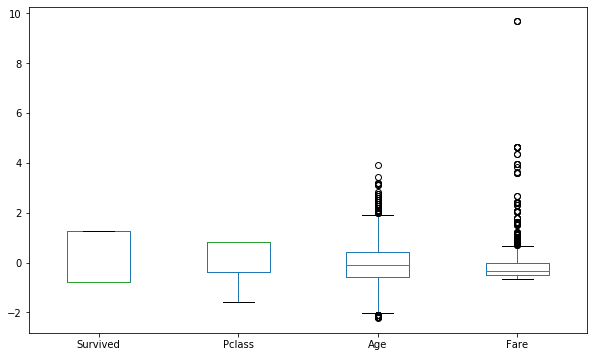

In [5]:
df.boxplot(grid=False, figsize=(10, 6))
plt.show()

we can see too many outliers in *Fare*, hence its histogram distribution on standardisation is skewed(since majority of the outliers on right, hence right-skewed).

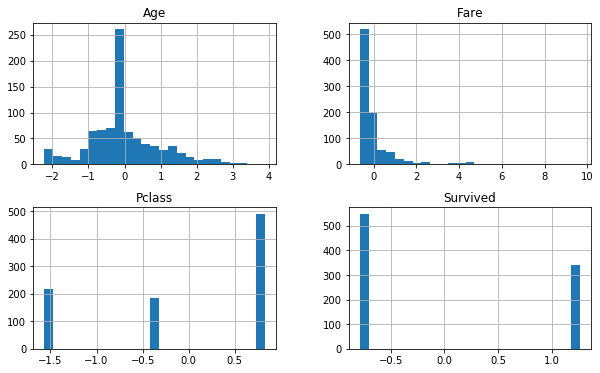

In [6]:
import matplotlib.pyplot as plt
df.hist(bins=25, figsize=(10, 6))
plt.show()

# Min-Max scaling
1. popularly used in CNN/deep-learning
2. scaling between [0,1]
3. $\bar{\textrm{x}} \, = \, \large \frac{\textrm{x} - \textrm{x}_{\textrm{min}}}{\textrm{x}_{\textrm{max}} - \textrm{x}_{\textrm{min}}}$

Survived    0
Pclass      0
Age         0
Fare        0
dtype: int64

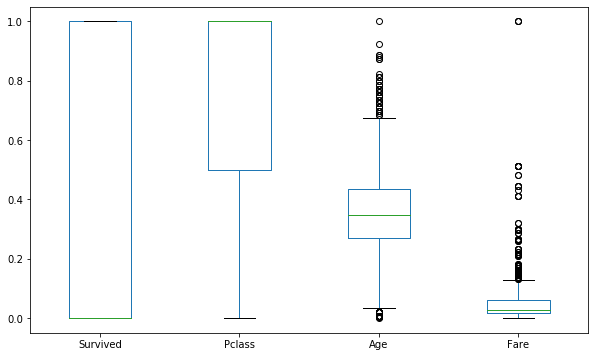

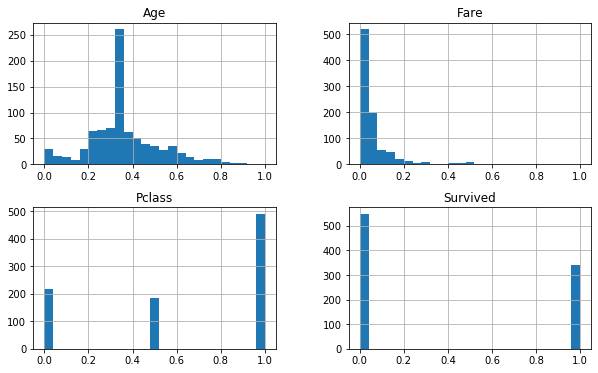

In [64]:
import pandas as pd
from IPython.display import display

df = pd.read_csv("./titanic-dataset/train.csv", usecols=['Pclass', 'Age', 'Fare', 'Survived'])

# fill up Age-NaN values
df['Age'].fillna(df['Age'].median(), inplace=True)
display(df.isnull().sum())

from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()
df = pd.DataFrame(min_max.fit_transform(df), columns=df.columns)

df.boxplot(grid=False, figsize=(10, 6))
plt.show()
df.hist(bins=25, figsize=(10, 6))
plt.show()

# Robust Scaler - scaling to median and quantiles
1. find out inter-quantile range
2. subtract median from all observations, divide the resulting quantity by interquantile difference(difference between the 75th quantile value(75$^{th}$ percentile value) and 25$^{th}$ quantile value(25$^{th}$ percentile value))
    * if y is the x-percentile of an array - x% of all value are less than this value y
3. this is to be used when the outliers are to be handled, since this method is more robust at handling them, than standardisation/min-max scaling.
    * since the presence of outliers might make the distribution skewed, this is to be employed, instead of the min-max scaling

Survived    0
Pclass      0
Age         0
Fare        0
dtype: int64

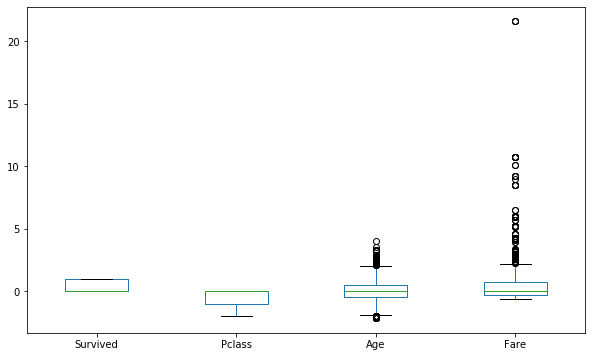

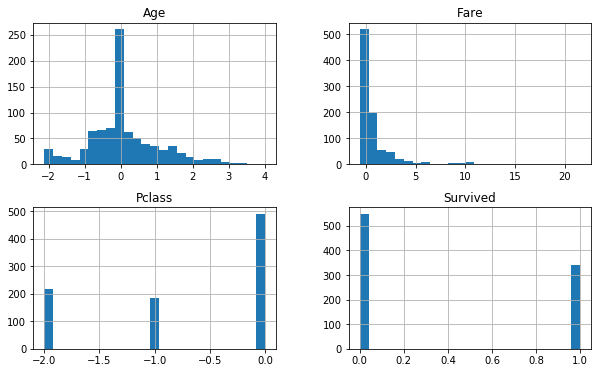

In [63]:
df = pd.read_csv("./titanic-dataset/train.csv", usecols=['Pclass', 'Age', 'Fare', 'Survived'])

# fill up Age-NaN values
df['Age'].fillna(df['Age'].median(), inplace=True)
display(df.isnull().sum())

from sklearn.preprocessing import RobustScaler
robust = RobustScaler()
df = pd.DataFrame(robust.fit_transform(df), columns=df.columns)

df.boxplot(grid=False, figsize=(10, 6))
plt.show()
df.hist(bins=25, figsize=(10, 6))
plt.show()

# Gaussian Transformation
* transform a non-normal distribution to a normal(i.e. a guassian one)
* models like linear and logistic regression work pretty well when features have a gaussian distribution
* use Q-Q plot to check whether a distribution is gaussian in nature or not.

## Logarithmic Transformation

Survived    0
Pclass      0
Age         0
Fare        0
dtype: int64

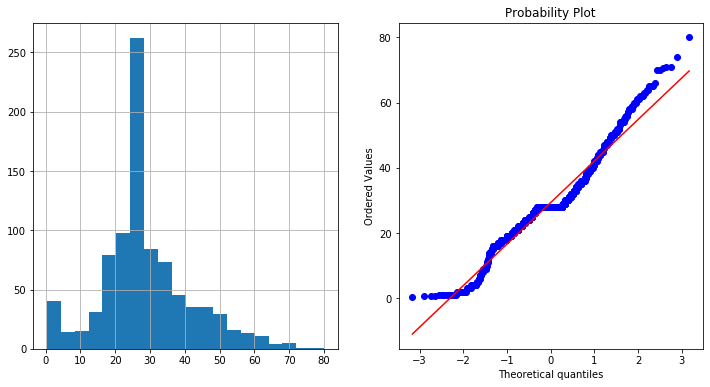

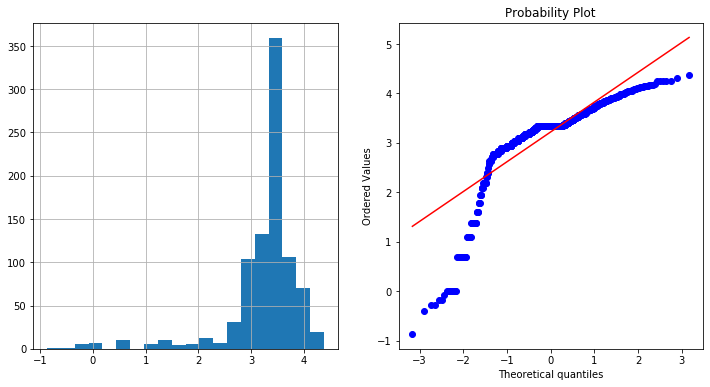

In [65]:
import pandas as pd
df = pd.read_csv("./titanic-dataset/train.csv", usecols=['Pclass', 'Age', 'Fare', 'Survived'])

# fill up Age-NaN values
df['Age'].fillna(df['Age'].median(), inplace=True)
display(df.isnull().sum())

import matplotlib.pyplot as plt
from scipy.stats import probplot
import pylab

def plot_feature(feat):
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    df[feat].hist(bins=20)
    plt.subplot(1, 2, 2)
    probplot(df[feat], dist='norm', plot=pylab)
    plt.show()

plot_feature('Age')

# logarithmic transformation for Age
import numpy as np
df['Age_log'] = np.log(df['Age'])
plot_feature('Age_log')

<font color="red">hence, since it falls out of the straight line, logarithmic transformation unsuitable for *Age feature*</font>

## Reciprocal transformation

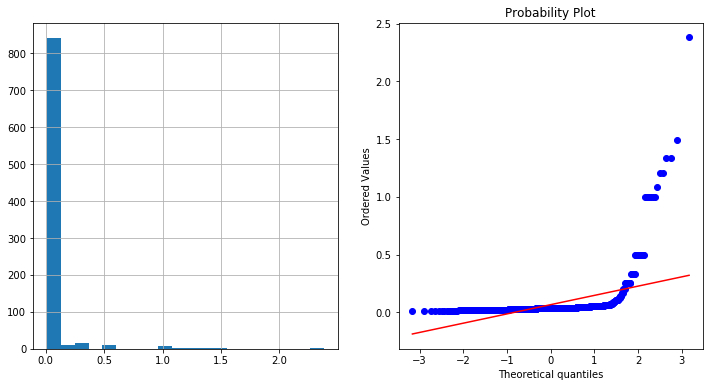

In [67]:
df['Age_recip'] = 1/df['Age']
plot_feature('Age_recip')

<font color="red">hence, since it falls out of the straight line, reciprocal transformation unsuitable for *Age feature*</font>

## Square-root transformation

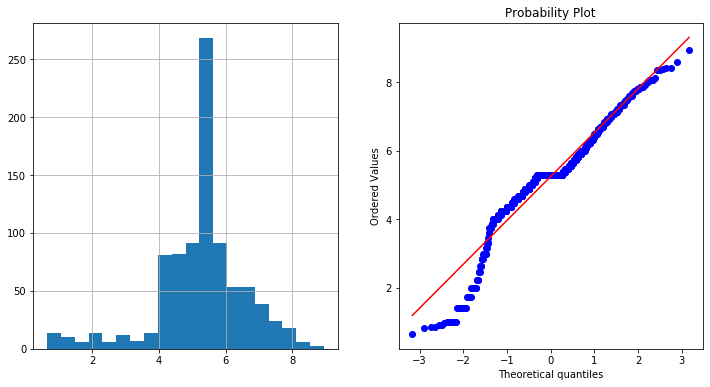

In [69]:
df['Age_sqrt'] = df['Age']**(1/2)
plot_feature('Age_sqrt')

## Exponential transformation

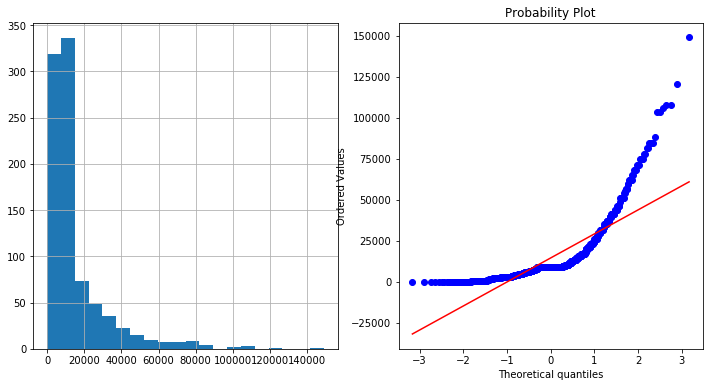

2.718281828459045


In [72]:
from math import exp
df['Age_exp'] = df['Age']**(exp(1))
plot_feature('Age_exp')
print(exp(1))

## BoxCox transformation

In [73]:
from scipy.stats import boxcox
df['Age_boxcox'] = boxcox(df['Age'])


(array([13.468119  , 21.4987284 , 15.56341683, 20.05611014, 20.05611014,
        16.58601436, 28.84746463,  0.92513402, 16.07664335,  9.01695462,
         2.53193075, 30.6104327 , 12.39181078, 21.97437834,  9.01695462,
        29.29062758,  0.92513402, 16.58601436, 18.09258499, 16.58601436,
        20.05611014, 19.56971919,  9.59722218, 16.58601436,  5.32265694,
        21.4987284 , 16.58601436, 11.84551333, 16.58601436, 16.58601436,
        22.44755196, 16.58601436, 16.58601436, 34.06447944, 16.58601436,
        23.38676361, 16.58601436, 12.93257404, 11.29332892,  9.01695462,
        22.44755196, 16.07664335, 16.58601436,  1.75636071, 11.84551333,
        16.58601436, 16.58601436, 16.58601436, 16.58601436, 11.29332892,
         4.65897047, 12.93257404, 26.60575762, 17.09169505, 33.6375945 ,
        16.58601436, 12.93257404, 16.83930618,  3.26857952,  7.221786  ,
        13.468119  , 21.4987284 , 24.77874367,  2.53193075, 16.58601436,
        16.58601436, 17.09169505, 11.84551333, 10.7

# Hashing Trick
1. [follow this link for now](https://booking.ai/dont-be-tricked-by-the-hashing-trick-192a6aae3087)